In [1]:
import pickle
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
import gzip

In [2]:
#load datasets

with open("../input/text-classification-2-feature-engineering/df_train.pkl", 'rb') as data:
    df_train = pickle.load(data)


with open("../input/text-classification-2-feature-engineering/df_test.pkl", 'rb') as data:
    df_test = pickle.load(data)
    

In [3]:
train_reviews = df_train['review_parsed'].values
test_reviews = df_test['review_parsed'].values

y_train = df_train['condition'].values
y_test = df_test['condition'].values

In [4]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_reviews)

X_train = tokenizer.texts_to_sequences(train_reviews)
X_test = tokenizer.texts_to_sequences(test_reviews)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

#look at example
print(train_reviews[2])
print(X_train[2])

severe lower back pain take  first dose last night  caffiene   keep  awake  night take another dose  morning  caffiene make  heart feel like  beat    chestthe codiene   medicine  help  back paini eat   take     upset  stomach    talk   doctor  switch  something else id  rather  plain old hydrocodone  caffiene 
[105, 311, 34, 21, 1, 12, 99, 57, 79, 118, 580, 79, 1, 186, 99, 152, 22, 373, 7, 15, 1136, 71, 29, 34, 74, 1, 575, 232, 345, 38, 96, 175, 276, 252, 540, 2593, 123, 1428]


In [5]:
#nn'ne verirken review uzunluklarını eşitliyoruz
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[ 94 338 534  17 352  55 358  37   1 544  63  44  29  82  27 175  53  25
 338 238 101  99  17  22 259   8  51  35 279  25  29  48  18 498   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [6]:
from keras.utils import to_categorical

# Convert the labels to one_hot_category values
y_train_1hot = to_categorical(y_train, num_classes = 10)
y_test_1hot = to_categorical(y_test, num_classes = 10)

In [7]:

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [8]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('../input/glove6b/glove.6B.50d.txt',tokenizer.word_index, embedding_dim)

In [9]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.46020791991233007

In [10]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [11]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model.add(layers.Conv1D(filters=50, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(units=50, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           1688150   
_________________________________________________________________
conv1d (Conv1D)              (None, 98, 50)            7550      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 50)            0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 50)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                80050     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5

Epoch 1/20
145/145 [==============================] - 4s 25ms/step - loss: 1.4650 - categorical_accuracy: 0.5093 - val_loss: 0.8563 - val_categorical_accuracy: 0.6957
Epoch 2/20
145/145 [==============================] - 4s 24ms/step - loss: 0.7526 - categorical_accuracy: 0.7281 - val_loss: 0.5798 - val_categorical_accuracy: 0.7886
Epoch 3/20
145/145 [==============================] - 3s 23ms/step - loss: 0.5716 - categorical_accuracy: 0.7923 - val_loss: 0.4792 - val_categorical_accuracy: 0.8253
Epoch 4/20
145/145 [==============================] - 3s 23ms/step - loss: 0.4861 - categorical_accuracy: 0.8229 - val_loss: 0.4311 - val_categorical_accuracy: 0.8440
Epoch 5/20
145/145 [==============================] - 3s 22ms/step - loss: 0.4364 - categorical_accuracy: 0.8410 - val_loss: 0.4040 - val_categorical_accuracy: 0.8528
Epoch 6/20
145/145 [==============================] - 3s 23ms/step - loss: 0.4048 - categorical_accuracy: 0.8527 - val_loss: 0.3800 - val_categorical_accuracy: 0.863

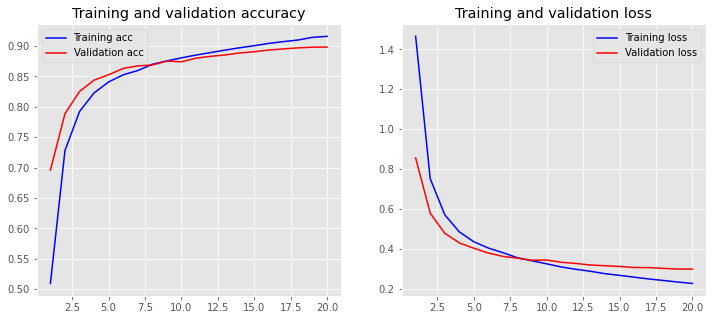

In [12]:
history = model.fit(X_train, y_train_1hot,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test_1hot),
                    batch_size=512)

loss_train, accuracy_train = model.evaluate(X_train, y_train_1hot, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy_train))

loss_test, accuracy_test = model.evaluate(X_test, y_test_1hot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy_test))

plot_history(history)

In [13]:
res_final_df=pd.DataFrame({'model_name': 'glove_CNN', 'train_acc': accuracy_train, 'test_acc': accuracy_test}, index=[0])

In [14]:
#save best model
model.save("glove_cnn.h5")

#pickle results
with gzip.open('glove_cnn_results.pkl', 'wb') as output:
    pickle.dump(res_final_df, output, protocol=-1)
    
#pickle tokenizer  
with open('keras-tokenizer.pkl', 'wb') as output:
    pickle.dump(tokenizer, output, protocol=-1)

#pickle embedding_matrix  
with open('embedding_matrix.pkl', 'wb') as output:
    pickle.dump(embedding_matrix, output, protocol=-1)

    